### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import os

# for building DQN model
import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam


# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# sample values list used to store the states tracked
sample_q_values = []

#Defining a function which will add new Q-values to the Q-dictionary
def add_to_dict(state,valid_act):
    
    if state not in Q_dict.keys():
        Q_dict[state] = {}
        Q_dict[state][action] = 0.0
            
#This function will initialise the 12 Q-values which need to be tracked for checking convergence
# the state-action will be picked randonly after the first 1000 episodes to ensure that there is data 

def initialise_tracking_states():
    samples = random.sample(list(Q_dict), 12)
    cnt = 0
    for i in samples:
        for j in Q_dict[i]: 
            if cnt < 12:
                sample_q_values.append((i,j))
                cnt += 1
            
    for q_values in sample_q_values:
        state_trk = q_values[0]
        action_trk = q_values[1]
        States_track[state_trk][action_trk] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         
        
#This function will append latest Q-values  which are being tracked for checking convergence
def save_tracking_states():
    for state_trk in States_track.keys():
        for action_trk in States_track[state_trk].keys():
            if state_trk in Q_dict and action_trk in Q_dict[state_trk]:
                States_track[state_trk][action_trk].append(Q_dict[state_trk][action_trk]) 

In [4]:
#Defining a function to save  as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size ,action_space):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.001
        
        self.terminal_hours = 720 #24 hrs for 30 days for terminal status
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        #get all the action space. Needed to get the action id for the train model
        self.action_space = action_space

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    #Read from the model pickle file if it exists else build a model
    def build_model(self):
        #check if the model file exists
        if os.path.isfile('./model.pkl'):
            model = pickle.load(open('model.pkl', 'rb'))
        else:
            model = Sequential()
            # Write your code here: Add layers to your neural nets       
            model.add(Dense(32, input_dim=self.state_size, activation='relu'))
            model.add(Dense(32, activation='relu'))

            # the output layer: output is of size num_actions
            model.add(Dense(self.action_size, activation='relu'))

            model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
            
        model.summary()
        return model



    def get_action(self, state, allowed_requests_labels):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions
             return [random.choice(allowed_requests_labels),0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)

            if (np.argmax(q_value[0]) in allowed_requests_labels): 
                return [np.argmax(q_value[0]),1]
            else:
                temp_label_best_qval = 0
                temp_label_best = 0
                for label in allowed_requests_labels:
                    if  temp_label_best_qval < q_value[0][label]:
                        temp_label_best_qval = q_value[0][label]
                        temp_label_best = label
                return [temp_label_best ,1]


    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
    
            
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size,self.state_size))# write here
            update_input = np.zeros((self.batch_size,self.state_size)) # write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action_s, reward_s, next_state = mini_batch[i]
                self.memory.popleft()
                update_input[i] = state
                update_output[i] = next_state
                actions.append(action_s)
                rewards.append(reward_s)
            
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input) #current state value

            # 2. Get the target for the Q-network
            target_q = self.model.predict(update_output) #state values for the next state as it is needed to calculate the q-value of the state-action  pair

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):

                action_id = self.action_space.index(actions[i])
                target[i][action_id] = rewards[i] + self.discount_factor * np.max(target_q[i])
                
            # 4. Fit your model and track the loss values
            loss = track_loss()
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0, callbacks=[loss])
            self.loss_lst = loss.loss_lst
            
    
    def save(self, name):
        self.model.save(name)
        
class track_loss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss_lst = []

    def on_batch_end(self, batch, logs={}):
        self.loss_lst.append(logs.get('loss'))
        


In [6]:
Episodes = 50000


### DQN block

In [7]:
model_threshold = 1000
threshold = 500
epsilon_factor = 0.0001

start_time = time.time()
# Call the environment
env = CabDriver()

#Initilize the state for the episode
state = env.state_init

action_size = len(env.action_space)
#Call the DQN agent
agent = DQNAgent(len(env.state_encod_arch1(state)), action_size, env.action_space)

score_lst = []
loss_lst = []
#initialize the q_value table
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
    
initialize = False    
if os.path.isfile('./States_tracked.pkl'):
    States_track = pickle.load(open('States_tracked.pkl', 'rb'))
    initialize = True


for episode in range(Episodes):
    
    # Write code here
    score = 0 # reset the score
    
    # Call all the initialised variables of the environment
    all_actions = env.action_space #Used as a reference for the actions

    state_size = len(env.state_space)

    #Update the epsilon value with decay rate
    #with the current factor the exploration happens till 8 thousand episodes and then the exploitation starts
    if agent.epsilon_max > agent.epsilon_min:
        #agent.epsilon_max = agent.epsilon_max * agent.epsilon_decay * np.exp(-epsilon_factor*episode)
        agent.epsilon_max = agent.epsilon_decay * np.exp(-epsilon_factor*episode)
    
    terminal_state = False
    hours_count = 0
    action_method = 0
    action_0_cnt = 0

    while not terminal_state:
        
        # Write your code here
        #Get the possible requests from the state
        requests = env.requests(state)

        agent.action_size = len(requests[0]) + 1
        # 1. Pick epsilon-greedy action from possible actions for the current state
        #convert the state to encoded state
        state_enc = env.state_encod_arch1(state)
        act_tup = agent.get_action(state_enc, requests[0])  #gives back the action and the boolean and int value of 1 for every action from the NN
        action_id  = act_tup[0]
        action  = env.action_space[action_id]
        if action_id == 0 : # to check how many times the option of (0,0) is used
            action_0_cnt += 1
            
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state ,action ,Time_matrix)
        next_state = env.next_state_func(state ,action ,Time_matrix)

        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action, reward, env.state_encod_arch1(next_state))
        score = score + reward

        action_method += act_tup[1]
        #Update the state to next state
        state = next_state    
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        #rewards and loss is tracked in the plot in the next step
        
        add_to_dict(state,action)
        st = env.state_encod_arch1(state)
        st1 = st.reshape(1,agent.state_size)
        Q_dict[state][action] = agent.model.predict(st1)[0][action_id]
                
        #keep track of the number of hrs for the terminal state
        #calculate the hours spend on this action
        if next_state[2] < state[1]:
            hrs_diff = (next_state[1]+23) - state[1]
        else:
            hrs_diff = next_state[1] - state[1]

        hours_count += hrs_diff
        if hours_count > agent.terminal_hours:
            terminal_state = True
            
    score_lst.append (score) # Track the score across episodes
    loss_lst.append (agent.loss_lst) #Track the Loss across each training of the mini batch
    
    #save the intermitent model
    if (episode+1) % model_threshold == 0:
        save_obj(agent.model, 'model')
        
    #Get random state from the Q_dict after 100 episodes
    if ((episode+1) == 100):  
        #only needed if the values are not loaded from the pickle files.
        if not initialize:
            initialise_tracking_states()
      
    if ((episode+1) % model_threshold) == 0:  
        save_tracking_states()
        save_obj(States_track,'States_tracked')  
        
    if ((episode+1) % model_threshold) == 0:
        print ("Episode: " + str(episode) + "| score: " + str(score) + '| NN used: ' +str(action_method) + '| Action (0,0) provided by Network- ' + str(action_0_cnt) + '| Loss- ' + str(agent.loss_lst))

end_time = time.time()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
Episode: 999| score: 116| NN used: 8| Action (0,0) provided by Network- 1| Loss- [572.71484]
Episode: 1999| score: 107| NN used: 10| Action (0,0) provided by Network- 0| Loss- [533.8607]
Episode: 2999| score: 138| NN used: 12| Action (0,0) provided by Network- 0| Loss- [830.2173]
Episode: 3999| score: 97| NN used: 10| Action (0,0) provided by Network- 1| Loss- [824.90906]
Episode

#### Observations
- Score for every episode keeps improving once the exploration reduces and exploitation increases as seen in the plot below.
- Post the 10000 episode there is a improvment in the scores

- Similar pattern is observed for the Loss for every episode. The loss is less when the netwrok is used instead of random values.


Time Taken -1867.8546891212463


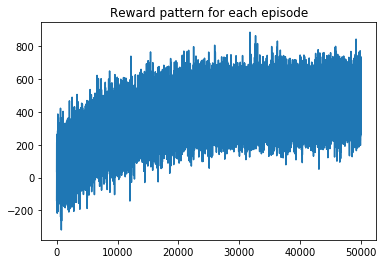

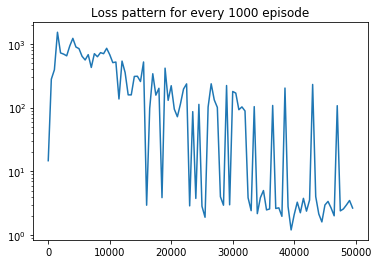

In [8]:
print ('Time Taken -' + str(end_time - start_time))

# Track the score (rewards) for the episodes
plt.plot(range(Episodes), score_lst)
plt.title('Reward pattern for each episode')
plt.show()

#Track loss for every 1000 episode to make it more discrete
discrete_loss_lst = []
for i in range(0,len(loss_lst)):
    if (i % 500 == 0):
        discrete_loss_lst.append((i ,loss_lst[i]))

x, y = zip(*discrete_loss_lst)

plt.plot(x, y)
plt.title('Loss pattern for every 1000 episode')
plt.yscale("log")
plt.show()




In [9]:
#Check the sample values in the q_dict
for state in States_track.keys():
    print (str(state) + ' - ' + str(Q_dict[state]))


(2, 23, 1) - {(0, 2): 216.54741, (4, 2): 228.98296, (3, 2): 239.65431, (0, 0): 228.8992}
(4, 3, 6) - {(0, 4): 247.24074, (1, 4): 0.0, (3, 4): 243.5982, (0, 0): 247.04813}
(0, 13, 0) - {(2, 0): 250.09715, (3, 0): 240.50722, (0, 0): 238.77159}
(3, 18, 6) - {(4, 3): 0.0, (1, 3): 245.24135, (0, 0): 228.38599}
(4, 4, 4) - {(0, 4): 259.3266, (2, 4): 261.2104, (3, 4): 249.93991, (1, 4): 0.0, (0, 0): 248.15477}
(0, 21, 4) - {(4, 0): 254.0587, (3, 0): 264.08713, (0, 0): 259.7206}
(3, 16, 5) - {(1, 3): 239.77135, (2, 3): 243.42754, (0, 3): 0.0, (0, 0): 233.14995}
(4, 2, 1) - {(3, 4): 245.5211, (0, 4): 241.78877, (2, 4): 241.5859, (1, 4): 0.0, (0, 0): 252.76218}


In [10]:
#sample_q_values

In [11]:
#States_track
# for state in States_track.keys():
#     for action in States_track[state].keys():
#         print (np.asarray(States_track[state][action]))

### Tracking Convergence
- Most of the states have converged as seen in the plot.
- Other states will converge if more episodes are used

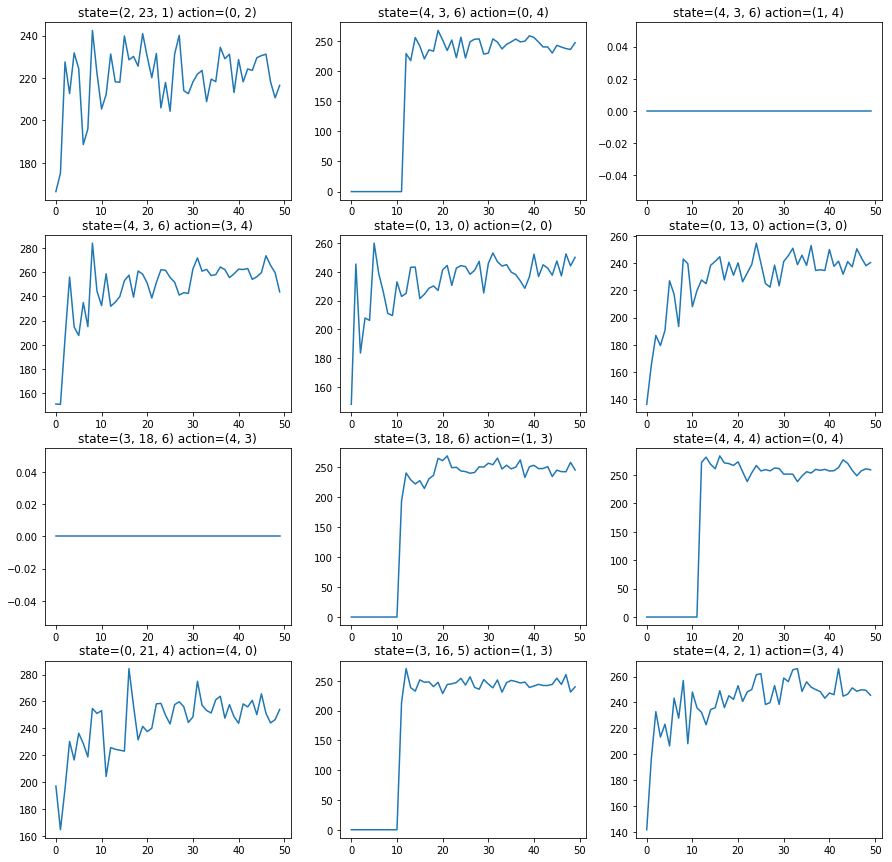

In [12]:
#Track the convergence using the states track dict
i = 0
j = 0

fig,axs = plt.subplots(4,3,figsize=(15,15))
for state in States_track.keys():
    for action in States_track[state].keys():
        axs[i,j].set_title('state='+str(state)+' action='+str(action))
        axs[i,j].plot (np.asarray(States_track[state][action]))
        if (j < 2):
            j += 1
        else :
            i += 1
            j = 0
plt.show() 

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,50000)
epsilon = []
val = 1
for i in range(0,50000):
    val =  0.99*np.exp(-0.0001*i)
    epsilon.append(val)

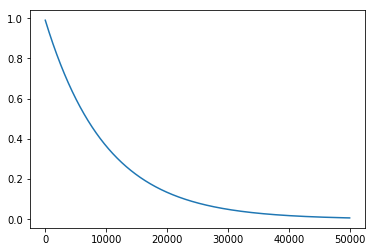

In [14]:
plt.plot(time, epsilon)
plt.show()